In [51]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

c = const.c.value
G = const.G.value
AU = (1*u.au).to('m').value
M_sun = const.M_sun.value
M_earth = const.M_earth.value

### Basic utility functions

In [52]:
def rel_len(x_1, x_2):
    r_vec = x_1 - x_2
    r = np.linalg.norm(r_vec)
    return r

def findrCM(x_1, x_2, m_1, m_2):
    M = m_1 + m_2
    r_cm = (m_1*x_1 + m_2*x_2)/M
    return r_cm

def γ(v, DL):
    if DL == True:
        c = 1
    else:
        c = const.c.value
    return 1/np.sqrt(1 - np.dot(v,v)/c**2)

### Acceleration equation and integration functions

In [53]:
def accelerationPM(x_1, x_2, v_1, v_2, m_1, m_2, DL, particle):
    if DL == True:
        G, c = 1, 1
    else:
        c = const.c.value
        G = const.G.value
    
    if particle == 1:
        p_vec = m_1*v_1
    else:
        p_vec = m_2*v_2

    r_vec = x_1 - x_2
    v_vec = v_1 - v_2

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)
    
    r_dot = np.dot(r_vec, v_vec)/r


    # WHAT ABOUT γ?!!?!?!
    p = np.linalg.norm(p_vec)


    E_1 = np.sqrt((m_1*c**2)**2 + (p*c)**2)
    E_2 = np.sqrt((m_2*c**2)**2 + (p*c)**2)
    c_1 = (m_1*m_2*c**2)**2 - 2*(E_1*E_2/c**2 + p**2)**2

    p_vec_dot = G*c_1/(E_1*E_2*r**3)*r_vec
    p_dot = np.linalg.norm(p_vec_dot)

    dE_1dp = p_vec*c**2/E_1
    dE_2dp = p_vec*c**2/E_2
    E_1_dot = np.dot(dE_1dp, p_vec_dot)
    E_2_dot = np.dot(dE_2dp, p_vec_dot)
    dE_1dp_dot = p_vec_dot*c**2/E_1 - p_vec*c**2/E_1**2*E_1_dot
    dE_2dp_dot = p_vec_dot*c**2/E_2 - p_vec*c**2/E_2**2*E_2_dot


    dc_1dp = -4*(E_1*E_2/c**2 + p**2)*((dE_1dp*E_2 + E_1*dE_2dp)/c**2 + 2*p_vec)
    c_1_dot = -4*(E_1*E_2/c**2 + p**2)*((E_1_dot*E_2 + E_1*E_2_dot)/c**2 + 2*np.dot(p_vec, p_vec_dot))
    dc_1dp_dot = -4*( ((E_1_dot*E_2 + E_1*E_2_dot)/c**2 + 2*p_vec*p_vec_dot)*((dE_1dp*E_2 + E_1*dE_2dp)/c**2 + 2*p_vec) + (E_1*E_2/c**2 + p**2)*((dE_1dp_dot*E_2 + dE_1dp*E_2_dot + E_1_dot*dE_2dp + E_1*dE_2dp_dot)/c**2 + 2*p_vec_dot) )


    q_dot = dE_1dp + dE_2dp + G/(E_1**2*E_2**2*r)*( E_1*E_2*dc_1dp - c_1*(dE_1dp*E_2 + E_1*dE_2dp) )


    a = dE_1dp_dot + dE_2dp_dot + G/(E_1**2*E_2**2*r)*(  -( r_dot/r + 2*E_1_dot/E_1 + 2*E_2_dot/E_2 )*( E_1*E_2*dc_1dp - c_1*(dE_1dp*E_1 + E_1*dE_2dp) ) + (E_1_dot*E_2 + E_1*E_2_dot)*dc_1dp + E_1*E_2*dc_1dp_dot - c_1_dot*(dE_1dp*E_2 + E_1*dE_2dp) - c_1*(dE_1dp_dot*E_2 + dE_1dp*E_2_dot + E_1_dot*dE_2dp + E_1*dE_2dp_dot) )
    

    return a

def boost(v_1, v_2, a_1, a_2, dt):
    v_1 += a_1*dt
    v_2 += a_2*dt
    return np.array([v_1, v_2])

def move(x_1, x_2, v_1, v_2, dt):
    x_1 += v_1*dt
    x_2 += v_2*dt
    return np.array([x_1, x_2])

# def boost1(v_vec, a, dt):
#     v_vec += a*dt
#     return v_vec

# def move1(r_vec, v_vec, dt):
#     r_vec += v_vec*dt
#     return r_vec

### This runs the simulation

In [54]:
def run_model(s, t_max, dt, DL = False):
    if DL == True:
        G, c = 1, 1
    else:
        c = const.c.value
        G = const.G.value
    
    x_1, x_2, v_1, v_2, m_1, m_2 = s
    
    R_S = 2*(m_1 + m_2)*G/c**2

    pos1 = np.zeros((2, int(t_max/dt)))
    pos2 = np.zeros((2, int(t_max/dt)))
    pos_CM = np.zeros((2, int(t_max/dt)))

    # r_init = rel_len(x_1, x_2)


    
    for i in range(int(t_max/dt)):
        # if rel_len(x_1, x_2) <= 5*R_S:
        #     print('Code interrupted: Radial Dip')
        #     pos1, pos2, pos_CM = pos1[:,0:i], pos2[:,0:i], pos_CM[:,0:i]
        #     break
        # elif rel_len(x_1, x_2) >= 5*r_init:
        #     print('Code interrupted: Max distance')
        #     pos1, pos2, pos_CM = pos1[:,0:i], pos2[:,0:i], pos_CM[:,0:i]
        #     break


        pos1[:,i] = x_1
        pos2[:,i] = x_2
        pos_CM[:,i] = findrCM(x_1, x_2, m_1, m_2)


        a_1 = accelerationPM(x_1, x_2, v_1, v_2, m_1, m_2, DL, particle = 1)
        a_2 = accelerationPM(x_1, x_2, v_1, v_2, m_1, m_2, DL, particle = 2)

        v_1, v_2 = boost(v_1, v_2, a_1, a_2, dt)
        x_1, x_2 = move(x_1, x_2, v_1, v_2, dt)

        # v_1 = boost1(v_1, a, dt)
        # x_1 = move1(x_1, v_1, dt)

    
    positions = np.array([pos1, pos2, pos_CM])
    return positions

### Plotting functions

In [55]:
def findMaxPos(pos):
    xmax, xmin, ymax, ymin = max(pos[0]), min(pos[0]), max(pos[1]), min(pos[1])
    return xmax, xmin, ymax, ymin

def plotLims(pos):
    start_pos = np.array([pos[0][0], pos[1][0]])
    end_pos = np.array([pos[0][-1], pos[1][-1]])

    xmax, xmin, ymax, ymin = findMaxPos(pos)
    max_pos = max(max(abs(start_pos)),max(abs(end_pos)))

    xlim = (xmin-0.1*max_pos, xmax+0.1*max_pos)
    ylim = (ymin-0.1*max_pos, ymax+0.1*max_pos)
    return xlim, ylim

def plotLimsTwoBody(pos1, pos2):
    start_pos1 = np.array([pos1[0][0], pos1[1][0]])
    end_pos1 = np.array([pos1[0][-1], pos1[1][-1]])
    start_pos2 = np.array([pos2[0][0], pos2[1][0]])
    end_pos2 = np.array([pos2[0][-1], pos2[1][-1]])

    x1max, x1min, y1max, y1min = findMaxPos(pos1)
    x2max, x2min, y2max, y2min = findMaxPos(pos2)

    xmax = max(x1max, x2max)
    xmin = min(x1min, x2min)
    ymax = max(y1max, y2max)
    ymin = min(y1min, y2min)

    max_pos1 = max(max(abs(start_pos1)),max(abs(end_pos1)))
    max_pos2 = max(max(abs(start_pos2)),max(abs(end_pos2)))
    max_pos = max(max_pos1, max_pos2)

    xlim = (xmin-0.1*max_pos, xmax+0.1*max_pos)
    ylim = (ymin-0.1*max_pos, ymax+0.1*max_pos)
    return xlim, ylim

def orbPlotter(positions, positionsN = 0, xlim = 0, ylim = 0, slice = slice(0, -1, 1), aspect = 1, filename='', CM = True, save = False, show = True, DL = False, N = False, figsize=(8,8)):
    if DL == False:
        x_1, x_2, x_cm = positions[0:3,:,slice]/149597871000
    else:
        x_1, x_2, x_cm = positions[0:3,:,slice]
    if CM == True:
        x_1 = x_1 - x_cm
        x_2 = x_2 - x_cm
        x_cm = np.zeros_like(x_1)

    fig, ax = plt.subplots(figsize=figsize)
    if type(xlim) != tuple:
        xlim = plotLimsTwoBody(x_1, x_2)[0]
    if type(ylim) != tuple:
        ylim = plotLimsTwoBody(x_1, x_2)[1]
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # if type(positionsN) == np.ndarray:
    #     if DL == False:
    #         x_1N, x_2N, x_cmN = positionsN[0:3,:,slice]/149597871000
    #     else:
    #         x_1N, x_2N, x_cmN = positionsN[0:3,:,slice]
    #     if CM == True:
    #         x_1N = x_1N - x_cmN
    #         x_2N = x_2N - x_cmN
    #     ax.plot(x_1N[0], x_1N[1], 'y', lw=0.5, label='Newtonian motion')
    #     ax.plot(x_2N[0], x_2N[1], 'y', lw=0.5, label='Newtonian motion')

    if CM == False:
        ax.plot(x_cm[0], x_cm[1], 'g:',label = 'CM')
        ax.plot(x_cm[0][0], x_cm[1][0], 'gx',markersize=8)
        ax.plot(x_cm[0][-1], x_cm[1][-1], 'g.',markersize=8)

    ax.plot(x_1[0], x_1[1],'b')
    ax.plot(x_1[0][0], x_1[1][0], 'bx', label = 'm_1 start', markersize=15)
    ax.plot(x_1[0][-1], x_1[1][-1], 'b.', label = 'm_1 stop',markersize=15)

    ax.plot(x_2[0], x_2[1],'r')
    ax.plot(x_2[0][0], x_2[1][0], 'rx', label = 'm_2 start', markersize=15)
    ax.plot(x_2[0][-1], x_2[1][-1], 'r.', label = 'm_2 stop',markersize=15)

    # if DL == True:
    #     ax.set_xlabel('$R_S$', fontsize = 15)
    #     ax.set_ylabel('$R_S$', fontsize = 15)
    # else:
    #     ax.set_xlabel('$x \ [\mathrm{AU}]$', fontsize = 15)
    #     ax.set_ylabel('$y \ [\mathrm{AU}]$', fontsize = 15)  
    ax.grid(c='grey', alpha=0.2, ls ='--')
    ax.set_aspect(aspect)
    ax.set_title(f'{filename}', fontsize = 20)
    ax.legend(facecolor='grey', fontsize = 12, bbox_to_anchor=(1.01,1), loc='upper left')

    plt.title(f'{filename}', fontsize=25, y=1.08)
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    if show == False:
        plt.close(fig)
    if save == True:
        fig.savefig(f'./Plots/{filename}.png', dpi=300, transparent = False)
    return

### Example case
We're not completely sure about the actual units yet...

In [ ]:
m_1 = 1e-4
m_2 = 1

R_S = 2*(m_1 + m_2)*G/c**2

x_1 = np.array([1000, 0.])
x_2 = np.array([0.,   0.])
v_1 = np.array([0., 0.01])
v_2 = np.array([0.,    0])
s = x_1, x_2, v_1, v_2, m_1, m_2

t_max = 202750*3
dt = 2

positions = run_model(s, t_max, dt, DL = True)

In [56]:
m_1 = b1_mass = 2
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

s = x_1, x_2, v_1, v_2, m_1, m_2

t_max = 5e4
res = 1e5
dt = t_max/res

positions = run_model(s, t_max, dt, DL = True)

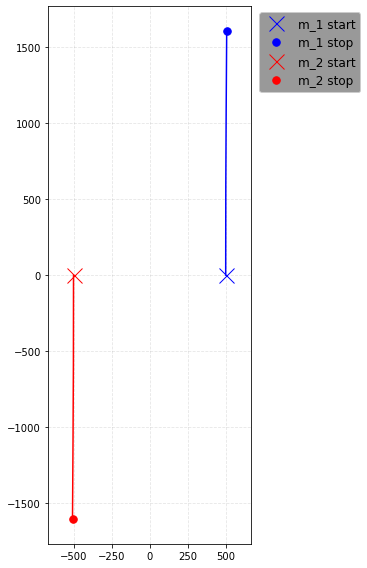

In [57]:
# lim = 1000
# orbPlotter(positions, DL = True, xlim=(-lim,lim), ylim=(-lim,lim))

orbPlotter(positions, DL = True, CM = True)

In [ ]:
dE_1dp_dot

In [42]:
positions[2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
m_1 = b1_mass = 1
m_2 = b2_mass = 2

R_S = 2*(b1_mass + b2_mass)*G/c**2

mass_bin = b1_mass + b2_mass
SMA_bin = 1000
v_redmass = np.sqrt(mass_bin/SMA_bin)
x_1 = CB_b1_posxyz_binCM  = np.array([ (b2_mass/mass_bin)*SMA_bin,  0])
x_2 = CB_b2_posxyz_binCM  = np.array([-(b1_mass/mass_bin)*SMA_bin,  0])
v_1 = CB_b1_velxyz_binCM  = np.array([0, (b2_mass/mass_bin)*v_redmass])
v_2 = CB_b2_velxyz_binCM  = np.array([0,-(b1_mass/mass_bin)*v_redmass])

In [47]:
v_1*m_1, v_2*m_2

(array([0.        , 0.03651484]), array([ 0.        , -0.03651484]))

In [50]:
-v_1*m_1/m_2, v_2

(array([-0.        , -0.01825742]), array([ 0.        , -0.01825742]))